In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 


# STEP 1: Data Setup and preprocessing
# Toy dataset with sentiment classification
sentences = [
    ("This food was disgusting", 0),
    ("Garden is beautiful", 1),
    ("House is poorly made", 0),
    ("Absolutely loved the movie", 1)
]

# Tokenization
# 1. Get all unique words from the dataset
words = set(word.lower() for sentence, _ in sentences for word in sentence.split())

# 2. Create a word index dictionary starting with 1. 0 is for padding
#  This is tokenization
word2idx = {word: i + 1 for i, word in enumerate(words)}
idx2word = {idx: word for word, idx in word2idx.items()}

# 3. Get number of words
vocab_size = len(word2idx) + 1

# 4. Max length of sentences
max_len = max(len(sentence.split()) for sentence, _ in sentences)

print("Vocabulary: ", word2idx)
print("Max sentence length: ", max_len)



Vocabulary:  {'this': 1, 'is': 2, 'food': 3, 'house': 4, 'garden': 5, 'loved': 6, 'the': 7, 'poorly': 8, 'disgusting': 9, 'made': 10, 'movie': 11, 'beautiful': 12, 'was': 13, 'absolutely': 14}
Max sentence length:  4


In [9]:
#  STEP 2: Text preprocessing - Encoding and padding
# Encode sentence
def encode_sentence(sentence):
    #  Returns a list of tokens related to the words in the sentence in the order of the sentence
    #  Essentially converting the sentence into a list of tokens
    return [word2idx[word.lower()] for word in sentence.split()]

# Pad the sentences to make sure all are the same size
def pad_sequence(seq, max_len):
    return seq + [0] * (max_len - len(seq))

encoded_data = []
for sentence, label in sentences:
    encoded = encode_sentence(sentence)
    padded = pad_sequence(encoded, max_len)
    encoded_data.append([padded, label])

print("Example encoded + padded:", encoded_data[1])




Example encoded + padded: [[5, 2, 12, 0], 1]


In [ ]:
#  STEP 3: DataSet and Dataloader
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)
    
dataset = SentimentDataset(encoded_data)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
# STEP 4: Self Attention Model
class SelfAttentionSentimentClassifier(nn.Module):

    def __init__(self, num_words, embed_dim):
        super().__init__() # We need to initialize base class so that pytorch can register submodules, and for layer tracking, .eval(), .train() etc.
        self.embedding = nn.Embedding(num_words, embed_dim)
        print("Embedding layer: ", self.embedding, "\n")
        self.q = nn.Linear(embed_dim, embed_dim) # parameters in_features, out_features, bias ( by default True)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, 2) # Binary Classification

    def forward(self, x):
        embed = self.embedding(x) # (B, T, D) B = batch size( number of input sequences ), T = Tokens per input sequence, D = Dimensions of each token
        print("Current embedding:", embed, "\n")
        Q = self.q(embed) 
        K = self.k(embed)
        V = self.v(embed)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5) # (B, T, T)
        print("QKt / size of Q: ", scores, "\n")
        attn_weights = f.softmax(scores, dim=-1)
        print("SOFTmax: ", attn_weights, "\n")
        attention_scores = torch.matmul(attn_weights, V)
        print("*V: ", attention_scores, "\n")

        pooled = attention_scores.mean(dim=1)
        print("Mean: ", pooled, "\n")
        out = self.fc(pooled)
        print("FC: ", out, "\n")
        return out, attn_weights





In [20]:
# STEP 5: Training Loop
model = SelfAttentionSentimentClassifier(vocab_size, embed_dim=3) # Model initialization
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # gradient-based weight optimizer. Updates model weights based on gradients computed during backprop
loss_fn = nn.CrossEntropyLoss() # Sending loss to optimizer to improve the model

for epoch in range(20):
    total_loss = 0
    for x, y in loader:
       optimizer.zero_grad()
       logits, _ = model(x)
       loss = loss_fn(logits, y)
       loss.backward()
       optimizer.step()
       total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}") 

Embedding layer:  Embedding(15, 3) 

Current embedding: tensor([[[ 0.1744,  0.2006,  2.1014],
         [ 0.6646,  0.9013, -1.9234],
         [-2.0484, -1.6120, -0.0655],
         [-0.0544,  1.1288, -0.0716]],

        [[ 1.8374, -0.3266,  0.2589],
         [-0.2603,  0.1526,  0.1830],
         [-1.2554, -0.1684, -0.0191],
         [-0.1580, -0.4169,  1.4129]]], grad_fn=<EmbeddingBackward0>) 

QKt / size of Q:  tensor([[[-0.1115,  0.2679,  0.5557, -0.0397],
         [-0.1164,  0.2011,  0.2139, -0.0555],
         [-1.1781,  1.4798, -0.0876, -0.4793],
         [-0.2228,  0.3296,  0.3783,  0.0048]],

        [[ 0.3101,  0.1345,  0.1605,  0.3568],
         [ 0.5559,  0.0461,  0.0061, -0.0844],
         [ 0.9117, -0.0293, -0.1766, -0.3175],
         [ 0.6600,  0.0719,  0.0276, -0.0100]]], grad_fn=<DivBackward0>) 

SOFTmax:  tensor([[[0.1823, 0.2665, 0.3553, 0.1959],
         [0.2071, 0.2845, 0.2882, 0.2201],
         [0.0494, 0.7044, 0.1469, 0.0993],
         [0.1719, 0.2987, 0.3136, 0.2158]

Current embedding: tensor([[[ 0.2962,  0.0798,  0.5609],
         [ 1.5366, -0.6780,  0.3462],
         [-1.6831, -0.3437,  1.1278],
         [ 0.0040,  0.1347, -0.5010]]]) 

QKt / size of Q:  tensor([[[ 0.0897,  0.7094, -0.6152,  0.1403],
         [ 0.3192,  0.6886,  0.3206, -0.1500],
         [ 0.1112,  1.9510, -2.2230,  0.6106],
         [ 0.0034,  0.9283, -1.2567,  0.3193]]]) 

SOFTmax:  tensor([[[0.2271, 0.4219, 0.1122, 0.2388],
         [0.2455, 0.3552, 0.2458, 0.1535],
         [0.1106, 0.6964, 0.0107, 0.1823],
         [0.1932, 0.4871, 0.0548, 0.2649]]]) 

*V:  tensor([[[-0.2802, -0.1262,  0.1395],
         [-0.2864, -0.1763,  0.1046],
         [-0.4936, -0.2302,  0.5219],
         [-0.3088, -0.1214,  0.2046]]]) 

Mean:  tensor([[-0.3423, -0.1635,  0.2426]]) 

FC:  tensor([[ 0.3566, -0.5694]]) 



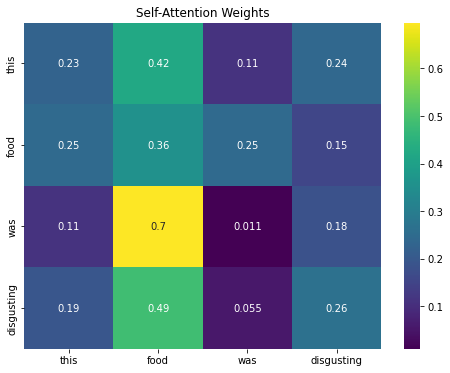

In [21]:
# STEP 6: Visualize attention
def show_attention(input_tensor, attn_weights):
    idxs = input_tensor[0].tolist()
    tokens = [idx2word.get(idx, "") for idx in idxs]
    attn = attn_weights[0].detach().numpy()

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis", annot=True)
    plt.title("Self-Attention Weights")
    plt.show()

# Pick one example and visualize
x, y = dataset[0]
model.eval()
with torch.no_grad():
    _, attn = model(x.unsqueeze(0))  # add batch dim
    show_attention(x.unsqueeze(0), attn)
